### Importing all the necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os
import zipfile
from PIL import Image

In [2]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

In [4]:
generator = Generator()
discriminator = Discriminator()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

# Loss Functions and Optimizers
adversarial_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [11]:
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

data_path = '/kaggle/input/gan-painter-dataset/'

photos_path = os.path.join(data_path, 'photo_jpg')
monet_path = os.path.join(data_path, 'monet_jpg')

photo_files = [os.path.join(photos_path, file) for file in os.listdir(photos_path)]
monet_files = [os.path.join(monet_path, file) for file in os.listdir(monet_path)]

In [12]:
class FlatImageDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

photo_dataset = FlatImageDataset(photo_files, transform=data_transforms)
monet_dataset = FlatImageDataset(monet_files, transform=data_transforms)

photo_loader = DataLoader(photo_dataset, batch_size=16, shuffle=True)
monet_loader = DataLoader(monet_dataset, batch_size=2, shuffle=True)


In [16]:
num_epochs = 30
for epoch in range(num_epochs):
    for i, (photo_batch, monet_batch) in enumerate(zip(photo_loader, monet_loader)):
        # Move data to device
        real_photos = photo_batch.to(device)
        real_monets = monet_batch.to(device)

        # Train Generator
        optimizer_G.zero_grad()
        fake_monets = generator(real_photos)
        validity = discriminator(fake_monets)
        g_loss = adversarial_loss(validity, torch.ones_like(validity)) + \
                 cycle_loss(generator(fake_monets), real_photos) + \
                 identity_loss(generator(real_photos), real_photos)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_validity = discriminator(real_monets)
        fake_validity = discriminator(fake_monets.detach())
        d_loss = (adversarial_loss(real_validity, torch.ones_like(real_validity)) + \
                 adversarial_loss(fake_validity, torch.zeros_like(fake_validity))) / 2
        d_loss.backward()
        optimizer_D.step()

        # Print Progress
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i}], G_Loss: {g_loss.item()}, D_Loss: {d_loss.item()}")

Epoch [1/30], Batch [0], G_Loss: 0.738347053527832, D_Loss: 0.24580498039722443
Epoch [1/30], Batch [10], G_Loss: 0.6539650559425354, D_Loss: 0.26085165143013
Epoch [1/30], Batch [20], G_Loss: 0.7183228135108948, D_Loss: 0.2799752652645111
Epoch [1/30], Batch [30], G_Loss: 0.6550039052963257, D_Loss: 0.20413833856582642
Epoch [1/30], Batch [40], G_Loss: 0.7091485857963562, D_Loss: 0.24809998273849487
Epoch [1/30], Batch [50], G_Loss: 0.6281311511993408, D_Loss: 0.26031696796417236
Epoch [1/30], Batch [60], G_Loss: 0.6944954991340637, D_Loss: 0.2726743221282959
Epoch [1/30], Batch [70], G_Loss: 0.6789027452468872, D_Loss: 0.19716057181358337
Epoch [1/30], Batch [80], G_Loss: 0.6778162717819214, D_Loss: 0.16616691648960114
Epoch [1/30], Batch [90], G_Loss: 0.743282675743103, D_Loss: 0.2018633335828781
Epoch [1/30], Batch [100], G_Loss: 0.6457135081291199, D_Loss: 0.19915960729122162
Epoch [1/30], Batch [110], G_Loss: 0.6330757737159729, D_Loss: 0.19395135343074799
Epoch [1/30], Batch [12

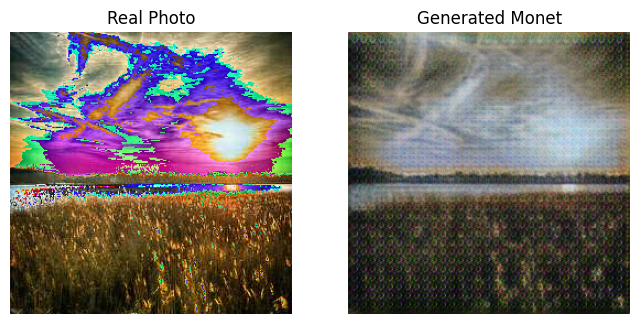

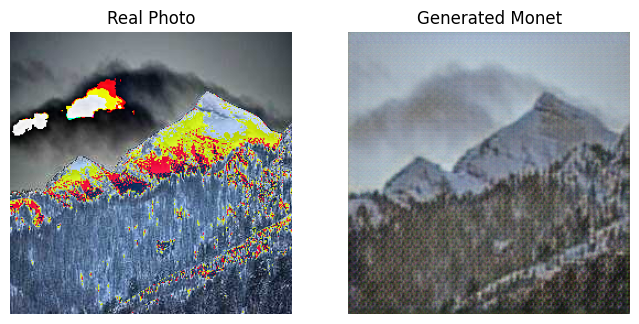

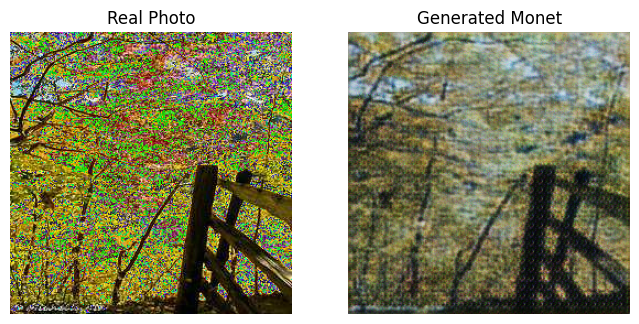

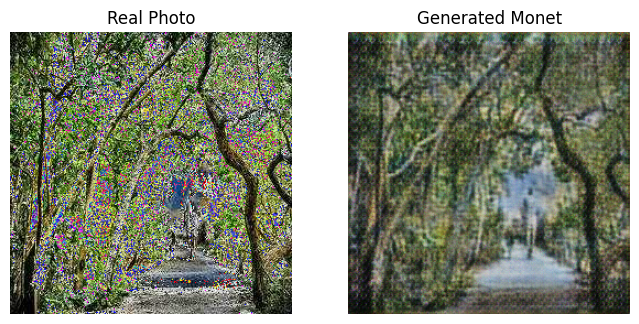

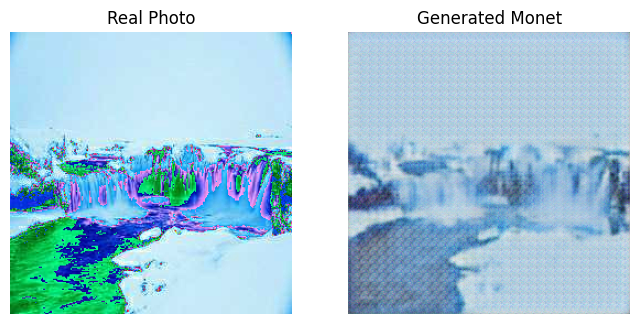

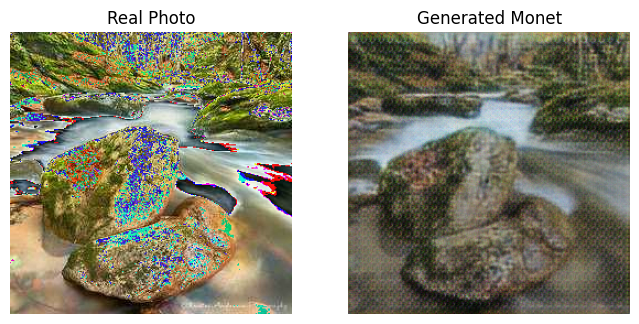

In [20]:
# Visualize Predictions
import matplotlib.pyplot as plt
def visualize_predictions(loader, generator, num_images=6):
    generator.eval()
    with torch.no_grad():
        for i, photo_batch in enumerate(loader):
            real_photos = photo_batch.to(device)
            fake_monets = generator(real_photos)
            fake_monets = (fake_monets * 0.5 + 0.5).clamp(0, 1)  # Denormalize to [0, 1]

            for j in range(min(num_images, len(fake_monets))):
                real_img = transforms.ToPILImage()(real_photos[j].cpu())
                fake_img = transforms.ToPILImage()(fake_monets[j].cpu())

                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1)
                plt.title("Real Photo")
                plt.imshow(real_img)
                plt.axis("off")

                plt.subplot(1, 2, 2)
                plt.title("Generated Monet")
                plt.imshow(fake_img)
                plt.axis("off")
                plt.show()

                num_images -= 1
                if num_images <= 0:
                    return

visualize_predictions(photo_loader, generator)

In [18]:
# Generate and Save Images
output_dir = "../tmp/generated_images"
os.makedirs(output_dir, exist_ok=True)

with zipfile.ZipFile("images.zip", "w") as zipf:
    image_counter = 1  # Initialize a global counter for unique file names
    for i, photo_batch in enumerate(photo_loader):
        real_photos = photo_batch.to(device)
        fake_monets = generator(real_photos)
        fake_monets = (fake_monets * 0.5 + 0.5).clamp(0, 1)  # Denormalize to [0, 1]

        for j, img in enumerate(fake_monets):
            img = transforms.ToPILImage()(img.cpu())
            img_path = os.path.join(output_dir, f"image_{image_counter}.jpg")
            img.save(img_path)
            zipf.write(img_path, os.path.basename(img_path))
            image_counter += 1  # Increment the counter for each image

            if image_counter > 8000:  # Stop after generating 8000 images
                break
        if image_counter > 8000:
            break